In [1]:
import pandas as pd
import numpy as np
import psycopg2
import pandas.io.sql as psql

In [2]:
dbname = 'everything2023'
user = ''
password = ''
host = 'pg.analytics.northwestern.edu'
port = '5432'

connection = psycopg2.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host,
    port=port
)

In [3]:
cursor = connection.cursor()
cursor.execute('''SELECT "SKU", "STORE", "SALEDATE", "QUANTITY", "STYPE", "ORGPRICE", "SPRICE", "AMT" FROM group_3.trnsact TABLESAMPLE SYSTEM(10);''')
result = cursor.fetchall()
trnsact = pd.DataFrame(result)

column_names = [desc[0] for desc in cursor.description]
trnsact.columns = column_names
trnsact

,SKU,STORE,SALEDATE,QUANTITY,STYPE,ORGPRICE,SPRICE,AMT
0,387,504,2005-07-29,1,P,79.0,79.0,79.0
1,387,504,2005-03-25,1,P,79.0,79.0,79.0
2,387,504,2005-05-07,1,P,79.0,79.0,79.0
3,387,504,2005-03-30,1,P,79.0,79.0,79.0
4,387,604,2005-08-16,1,P,79.0,79.0,79.0
...,...,...,...,...,...,...,...,...
11229586,9999950,9806,2004-11-10,1,P,13.5,13.5,13.5
11229587,9999950,9806,2005-04-11,1,P,13.5,13.5,13.5
11229588,9999950,9806,2005-04-13,1,P,13.5,13.5,13.5
11229589,9999950,9806,2005-02-21,1,P,13.5,13.5,13.5


In [24]:
cursor.execute('''SELECT * FROM group_3.skstinfo;''')
result = cursor.fetchall()
skstinfo = pd.DataFrame(result)

column_names = [desc[0] for desc in cursor.description]
skstinfo.columns = column_names
skstinfo

,SKU,STORE,COST,RETAIL,UNCLEAR
0,377020,704,17.9,11.0,0
1,377020,707,17.9,11.5,0
2,377020,709,17.9,11.0,0
3,377020,802,8.0,22.0,0
4,377020,807,17.9,11.5,0
...,...,...,...,...,...
39100546,377020,504,17.9,11.0,0
39100547,377020,507,17.9,11.5,0
39100548,377020,603,17.9,24.99,0
39100549,377020,604,17.9,11.0,0


In [27]:
cursor.close()
connection.close()

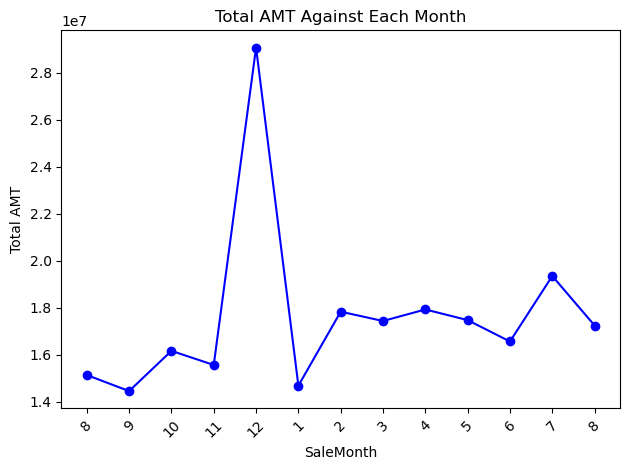

In [4]:
import datetime as dt
import matplotlib.pyplot as plt

trnsact['SALEDATE'] = pd.to_datetime(trnsact['SALEDATE'])
trnsact['SaleYear'] = trnsact['SALEDATE'].dt.year
trnsact['SaleMonth'] = trnsact['SALEDATE'].dt.month

trnsact.loc[trnsact['STYPE'] == 'R', 'AMT'] = -trnsact.loc[trnsact['STYPE'] == 'R', 'AMT']
monthly_sales = trnsact.groupby(['SaleYear', 'SaleMonth'])['AMT'].sum().reset_index()

plt.plot(monthly_sales.index, monthly_sales['AMT'], marker='o', linestyle='-', color='b')
plt.xlabel('SaleMonth')
plt.ylabel('Total AMT')
plt.title('Total AMT Against Each Month')
plt.xticks(monthly_sales.index, monthly_sales['SaleMonth'], rotation=45)
plt.tight_layout()
plt.show()

In [5]:
monthlydiscount = trnsact[trnsact['ORGPRICE'] != trnsact['SPRICE']].groupby(['SaleYear', 'SaleMonth']).SKU.count()
monthlydiscount = monthlydiscount.reset_index().rename(columns={'SKU': 'discount_item_num'})
monthlysales = trnsact.groupby(['SaleYear', 'SaleMonth']).SKU.count()
monthlysales = monthlysales.reset_index().rename(columns={'SKU': 'total_item_num'})

discount_percentage = pd.merge(monthlydiscount, monthlysales, on = ['SaleYear', 'SaleMonth'], how = 'inner')
discount_percentage['percentage'] = discount_percentage['discount_item_num'] / discount_percentage['total_item_num']
discount_percentage

,SaleYear,SaleMonth,discount_item_num,total_item_num,percentage
0,2004,8,412528,772359,0.534114
1,2004,9,507939,837218,0.606699
2,2004,10,275991,779134,0.354228
3,2004,11,259911,647420,0.401457
4,2004,12,579693,1239275,0.467768
5,2005,1,527835,820287,0.643476
6,2005,2,736234,1057829,0.695986
7,2005,3,394090,836347,0.471204
8,2005,4,269978,847842,0.318430
9,2005,5,270621,717832,0.376998


In [11]:
trnsact['AMT'] = pd.to_numeric(trnsact['AMT'], errors='coerce')
df_date = pd.pivot_table(trnsact, values = ["AMT"], index = ['SALEDATE'], aggfunc = {'AMT': 'sum'}).reset_index()
df_date

,SALEDATE,AMT
0,2004-08-01,381777.12
1,2004-08-02,347834.64
2,2004-08-03,412062.87
3,2004-08-04,426757.03
4,2004-08-05,478258.95
...,...,...
384,2005-08-23,426621.92
385,2005-08-24,723556.67
386,2005-08-25,651376.76
387,2005-08-26,763720.35


<Axes: title={'center': 'Total income amount of the transaction charge against time'}, xlabel='SALEDATE'>

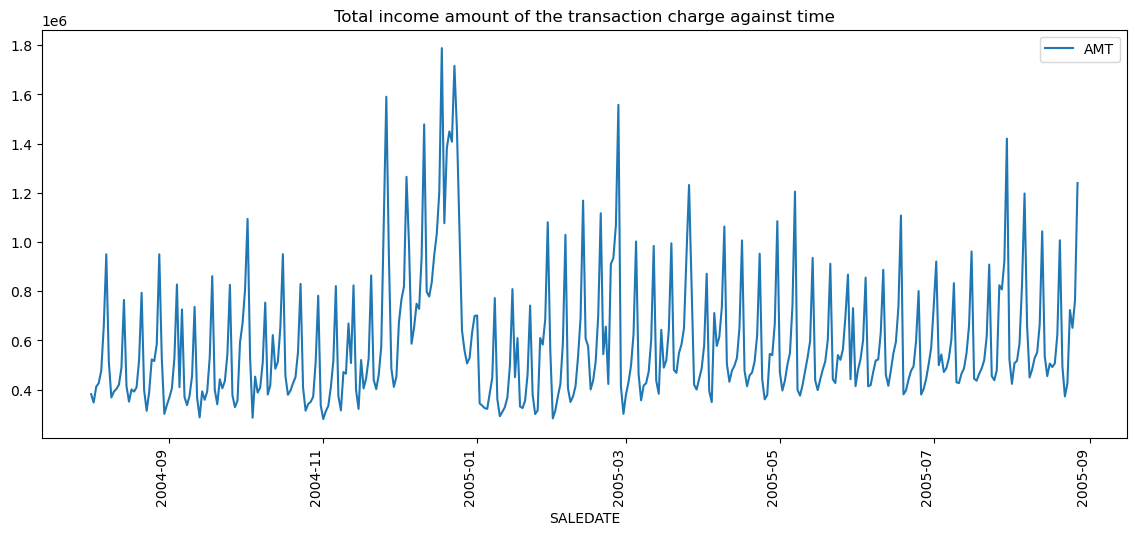

In [12]:
df_date.plot.line(x = "SALEDATE", y = "AMT", figsize = (14,6), title = "Total income amount of the transaction charge against time", rot = 90)

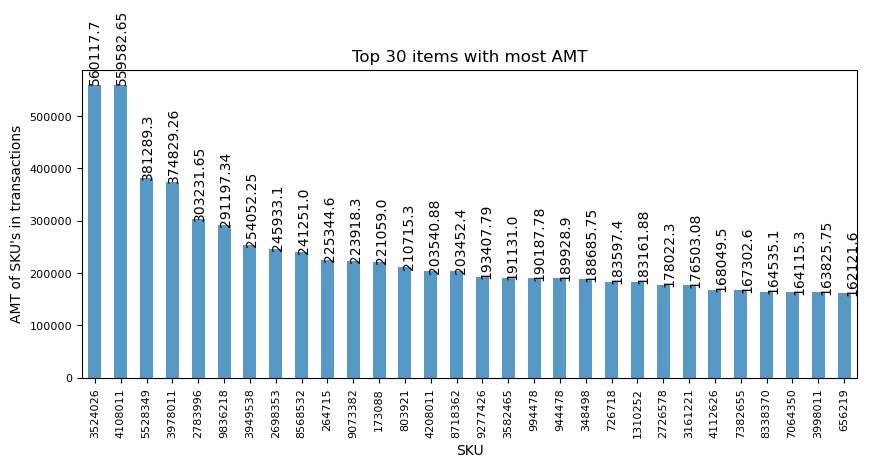

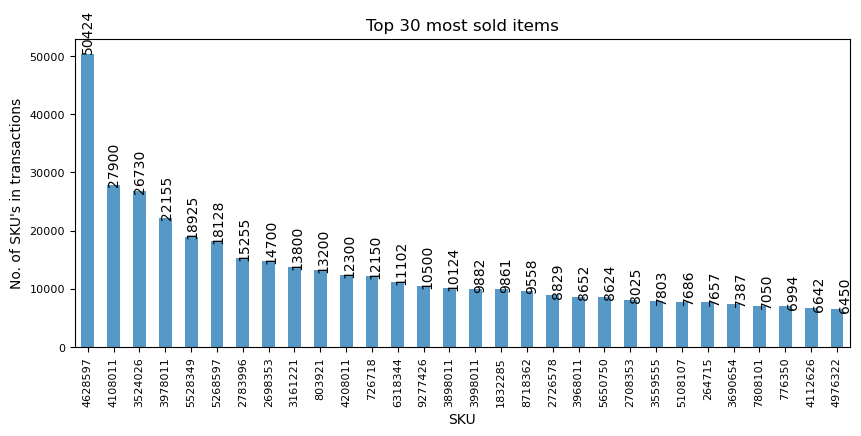

In [22]:
SKU_transactions = trnsact.groupby("SKU")['AMT'].sum().sort_values(ascending = False).head(30)

ax = SKU_transactions.plot(kind = 'bar', rot = 90, fontsize = 8, alpha = 0.75, figsize = (10,4))
plt.title("Top 30 items with most AMT")
plt.xlabel("SKU")
plt.ylabel("AMT of SKU's in transactions")

for i in ax.patches:
    ax.annotate(str(i.get_height()), 
               (i.get_x()*1.01, i.get_height()*1.01),
               rotation = 90)
plt.show()

SKU_count = trnsact.SKU.value_counts().head(30)

ax = SKU_count.plot(kind = 'bar', rot = 90, fontsize = 8, alpha = 0.75, figsize = (10,4))
plt.title("Top 30 most sold items")
plt.xlabel("SKU")
plt.ylabel("No. of SKU's in transactions")

for i in ax.patches:
    ax.annotate(str(i.get_height()), 
               (i.get_x()*1.01, i.get_height()*1.01),
               rotation = 90)
plt.show()

In [30]:
# check if retail price is equal to orgprice
merged_table = pd.merge(skstinfo, trnsact, on = ['SKU', 'STORE'], how = 'inner')
merged_table
# merged_table[merged_tabled['RETAIL'] != merged_table['ORGPRICE']]

,SKU,STORE,COST,RETAIL,UNCLEAR,SALEDATE,QUANTITY,STYPE,ORGPRICE,SPRICE,AMT,SaleYear,SaleMonth
0,377020,3607,17.9,11.5,0,2005-07-02,1,P,46.0,19.99,19.99,2005,7
1,377020,3607,17.9,11.5,0,2005-04-25,1,P,46.0,29.99,29.99,2005,4
2,377020,3702,8.0,22.0,0,2005-02-10,1,P,44.0,44.0,44.00,2005,2
3,377020,3702,8.0,22.0,0,2005-06-18,1,P,44.0,29.99,29.99,2005,6
4,377020,3704,17.9,11.0,0,2005-03-31,1,P,44.0,29.99,29.99,2005,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6291159,376855,3802,2.88,1.75,0,2005-08-26,1,P,7.0,2.81,2.81,2005,8
6291160,376855,3902,2.88,1.75,0,2005-02-23,1,P,7.0,2.1,2.10,2005,2
6291161,376855,4204,2.88,4.69,0,2005-03-30,1,P,7.0,4.69,4.69,2005,3
6291162,376855,4302,2.88,1.75,0,2005-03-26,1,P,7.0,1.75,1.75,2005,3


In [ ]:
merged_table['Revenue'] = (merged_table['SPRICE'] - merged_table['COST']) * merged_table['QUANTITY']
merged_table.loc[merged_table['STYPE'] == 'R', 'Revenue'] = -trnsact.loc[trnsact['STYPE'] == 'R', 'Revenue']
df_date_revenue = pd.pivot_table(merged_table, values = ["Revenue"], index = ['SALEDATE'], aggfunc = {'Revenue': 'sum'}).reset_index()
df_date_revenue

In [ ]:
df_date_revenue.plot.line(x = "SALEDATE", y = "Revenue", figsize = (14,6), title = "Total gross revenue against time", rot = 90)

## Store

In [23]:
df_store = pd.pivot_table(trnsact,
                          values = ['SKU', "QUANTITY", "SPRICE", "AMT"],
                          index = ['STORE'], 
                          aggfunc = {'SKU':'count',
                                     'QUANTITY': 'sum',
                                     'AMT':[np.mean, 'sum']})

df_store

AMT             QUANTITY    SKU
            mean         sum      sum  count
STORE                                       
102    25.031876  1271393.99    50791  50791
103    21.773363   986747.06    45319  45319
107    21.688170  1509908.68    69619  69619
202    18.448009   545710.56    29581  29581
203    19.180866   820365.63    42770  42770
...          ...         ...      ...    ...
9704   18.227108   307400.17    16865  16865
9709   17.252590   422464.18    24487  24487
9804   19.720595   456255.68    23136  23136
9806   33.970199  1421992.51    41860  41860
9909   19.074055   401737.75    21062  21062

[329 rows x 4 columns]